In [5]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from typing import List

import numpy as np
import cv2

import torch
import torch.linalg as LA

from camera_transition import CameraTransition
from models import (
    ActorImprovedValue,
    CriticTD,
    ActorModel,
    CriticModel)
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def torch_rodrigues(mat):
    U, _, V_T = LA.svd(mat)
    R = U @ V_T
    r1 = R[:, 2, 1] - R[:, 1, 2]
    r2 = R[:, 0, 2] - R[:, 2, 0]
    r3 = R[:, 1, 0] - R[:, 0, 1]

    r = torch.stack((r1, r2, r3), 1)
    s = LA.norm(r, dim=1) / 2
    c = (R[:, 0, 0] + R[:, 1, 1] + R[:, 2, 2] - 1) / 2
    c = torch.clip(c, -1., 1.)
    theta = torch.acos(c)
    vth = 1 / (2 * s)
    r = r.T * vth * theta
    return r.T

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

camera_mat = torch.tensor([
    [633.09029639, 0., 629.06462963],
    [0., 638.7544391, 362.74013262],
    [0., 0., 1.]
])
target_points = torch.tensor([
    [822.75,     362.25],
    [755.25,     476.25],
    [624.75,     476.25],
    [554.25,     366.75],
    [618.75,     273.75],
    [755.25,     270.75]
    ])
points_env = torch.tensor([
    [2, 0, 4],
    [1, 1.66, 4],
    [-1, 1.66, 4],
    [-2, 0, 4],
    [-1, -1.66, 4],
    [1, -1.66, 4],
])

camera_transition = CameraTransition(
    device,
    camera_mat,
    target_points,
    points_env,
    100.
)

In [8]:
optimizer_critic_kind = torch.optim.Adam
optimizer_critic_parameters = {
    'lr': 1e-8,
    'weight_decay': 1e-5
}

optimizer_actor_kind = torch.optim.Adam
optimizer_actor_parameters = {
    "lr" : 1e-8,
    "weight_decay" : 1e-5
}

critic_iterations = 300
critic_batch_size = 2000

actor_iterations = 300
actor_batch_size = 2000

epochs = 100

In [9]:
actor = ActorModel().to(device)
critic = CriticModel().to(device)

critic_temporal_difference = CriticTD(actor, critic, camera_transition).to(device)
actor_improved_value = ActorImprovedValue(actor, critic, camera_transition).to(device)

In [10]:
def visualize_scatter(orig_coords, old_coords, new_coords):
    plt.scatter( orig_coords[:,0], orig_coords[:, 1], c=range(6), marker='x')
    plt.scatter( old_coords[:,0], old_coords[:, 1], c=range(6), marker='o')
    plt.scatter( new_coords[:,0], new_coords[:, 1], c=range(6), marker='^')
    plt.show()

In [11]:
def get_start_position(bs):
    return torch.hstack([torch.Tensor(np.random.uniform(-2, 2, (bs, 3)).astype(np.float64)),
                         torch.Tensor(np.random.uniform(-.5, .5, (bs, 3)).astype(np.float64))])

SCALES = torch.tensor([0.1, 0.1, 0.1, 0.5, 0.5, 0.5])
def critic_epoch(optimizer: torch.optim.Optimizer,
                 model: CriticTD, 
                 iterations: int, 
                 batch_size: int) -> List[float]:
    losses = []
    for iteration in tqdm(range(iterations), "Critic epoch"):
        # Поменять на наши ограничения позиции
#         scales = SCALES
#         X = (torch.rand((batch_size, 6)) * scales * 2 - scales).to(device)
        X = get_start_position(batch_size).to(device)
        optimizer.zero_grad()
        loss = model(X)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    print("Critic mean loss:", np.mean(losses), "[%f --> %f]" % (np.mean(losses[0:10]), np.mean(losses[-10:-1])))
    return losses

def actor_epoch(optimizer: torch.optim.Optimizer,
                 model: CriticTD, 
                 iterations: int, 
                 batch_size: int) -> List[float]:
    values = []
    for iteration in tqdm(range(iterations), "Actor epoch"):
        # Поменять на наши ограничения позиции
#         scales = SCALES
#         X = (torch.rand((batch_size, 6)) * scales * 2 - scales).to(device)
        X = get_start_position(batch_size).to(device)
        optimizer.zero_grad()
        improved_value = model(X)
        improved_value.backward()
        optimizer.step()
        values.append(improved_value.detach().cpu().numpy())
    print("Actor mean value:", np.mean(values), "[%f --> %f]" % (np.mean(values[0:10]), np.mean(values[-10:-1])))

    state = X[-1].unsqueeze(0)
#     print('state', state.shape)
    new_state = actor.forward(state)[0]
    ct = camera_transition(state, new_state)
    op = camera_transition._project_points(state).detach().numpy()
    new = camera_transition._project_points(ct[0]).detach().numpy()
#     print(op, '\n\n', new)
    visualize_scatter(
        np.array(target_points), 
        np.array(op[0]), 
        np.array(new[0])
    )
    return values

In [12]:
optimizer_actor = optimizer_actor_kind(actor_improved_value.parameters(), **optimizer_actor_parameters)

Critic epoch:  81%|████████  | 242/300 [00:19<00:04, 11.99it/s]


Critic epoch: 100%|██████████| 300/300 [00:24<00:00, 12.27it/s]


Critic mean loss: 314447300.0 [314511232.000000 --> 314484064.000000]



Actor epoch:  83%|████████▎ | 248/300 [00:16<00:03, 15.37it/s]


Actor epoch: 100%|██████████| 300/300 [00:20<00:00, 14.82it/s]


Actor mean value: 11999.973 [11999.950195 --> 11999.970703]


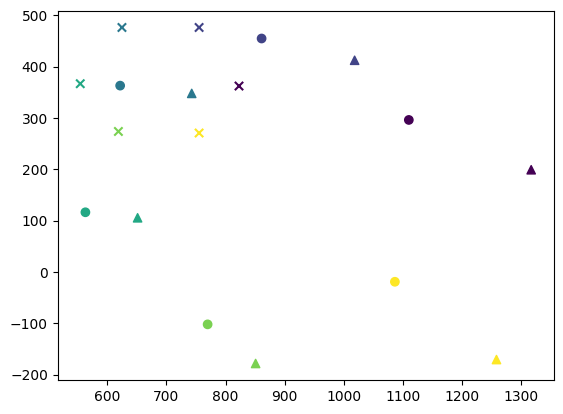

Critic epoch:  80%|████████  | 241/300 [00:19<00:04, 12.82it/s]


Critic epoch: 100%|██████████| 300/300 [00:24<00:00, 12.44it/s]


Critic mean loss: 314451840.0 [313971424.000000 --> 314272096.000000]



Actor epoch:  83%|████████▎ | 248/300 [00:16<00:03, 14.44it/s]


Actor epoch: 100%|██████████| 300/300 [00:20<00:00, 14.79it/s]


Actor mean value: 11999.98 [11999.984375 --> 11999.970703]


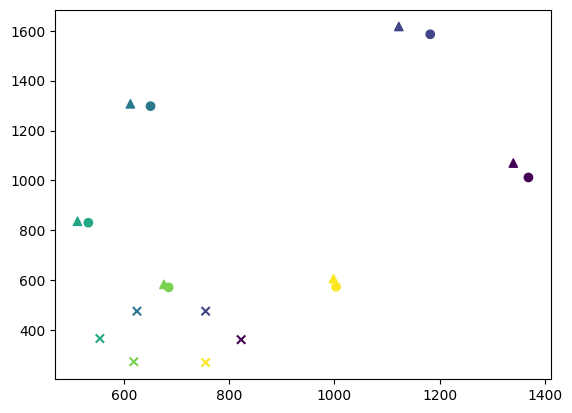

Critic epoch:  81%|████████  | 242/300 [00:19<00:04, 12.43it/s]


Critic epoch: 100%|██████████| 300/300 [00:24<00:00, 12.28it/s]


Critic mean loss: 314398660.0 [313720672.000000 --> 314715264.000000]



Actor epoch:  83%|████████▎ | 248/300 [00:17<00:03, 14.92it/s]


Actor epoch: 100%|██████████| 300/300 [00:20<00:00, 14.53it/s]


Actor mean value: 11999.97 [11999.941406 --> 11999.989258]


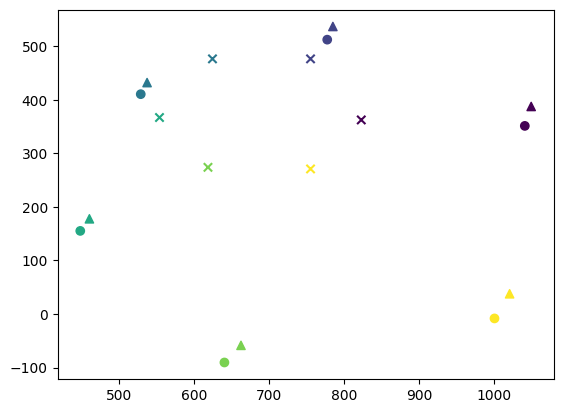

Critic epoch:  81%|████████  | 242/300 [00:19<00:04, 11.76it/s]


Critic epoch: 100%|██████████| 300/300 [00:24<00:00, 12.20it/s]


Critic mean loss: 314413540.0 [314508128.000000 --> 313833600.000000]



Actor epoch:  83%|████████▎ | 248/300 [00:16<00:03, 15.38it/s]


Actor epoch: 100%|██████████| 300/300 [00:19<00:00, 15.00it/s]


Actor mean value: 11999.9795 [12000.000000 --> 11999.984375]


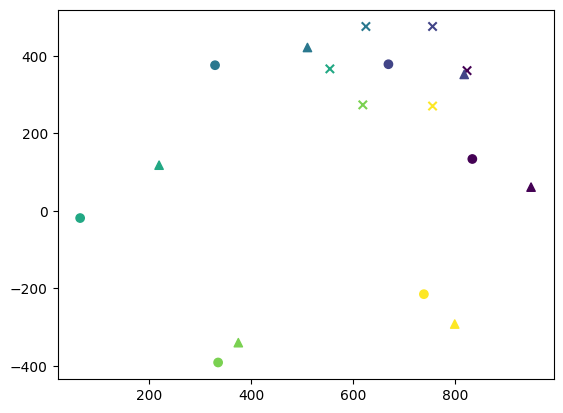

Critic epoch:  62%|██████▏   | 186/300 [00:15<00:09, 12.15it/s]

In [ ]:
for _ in tqdm(range(epochs), "Actor-Critic learning"):
    optimizer_critic = optimizer_critic_kind(critic_temporal_difference.parameters(), **optimizer_critic_parameters) ## It is important to reinitialize the critic optimizer to erase irrelevant momenta and adaptations
    values = np.array(critic_epoch(optimizer_critic, 
                                   critic_temporal_difference,
                                   critic_iterations,
                                   actor_batch_size))
    actor_epoch(optimizer_actor, 
                actor_improved_value,
                actor_iterations,
                actor_batch_size)

In [ ]:
actor(torch.tensor([0., 0., 1., 0.1, 0.1, 0.]).to(device))

In [ ]:
np.random.uniform??

In [ ]:
import matplotlib.pyplot as plt
plt.scatter( np.array([
    [822.75,     362.25],
    [755.25,     476.25],
    [624.75,     476.25],
    [554.25,     366.75],
    [618.75,     273.75],
    [755.25,     270.75]])[:,0],
            np.array([
                [822.75,     362.25],
    [755.25,     476.25],
    [624.75,     476.25],
    [554.25,     366.75],
    [618.75,     273.75],
    [755.25,     270.75]])[:,1], c=range(6))

In [ ]:
torch.hstack([torch.Tensor(np.random.uniform(-.1, .1, (2,3)).astype(np.float64)), torch.Tensor(np.random.uniform(-.5, .5, (2,3)).astype(np.float64))])
# torch.Tensor([*np.random.uniform(-.1, .1, 3).astype(np.float64), *np.random.uniform(-.5, .5, 3).astype(np.float64)]*2)

In [ ]:
# camera_transition = CameraTransition(
#     device,
#     camera_mat,
#     target_points,
#     points_env,
#     100.
# )
camera_transition._project_points(torch.Tensor([[0,0,0,0,0,0]]))

In [ ]:
plt.scatter( np.array([
    [822.75,     362.25],
    [755.25,     476.25],
    [624.75,     476.25],
    [554.25,     366.75],
    [618.75,     273.75],
    [755.25,     270.75]])[:,0],
            np.array([
                [822.75,     362.25],
    [755.25,     476.25],
    [624.75,     476.25],
    [554.25,     366.75],
    [618.75,     273.75],
    [755.25,     270.75]])[:,1], c=range(6),marker='x')
plt.scatter( np.array([
    [945.6097, 362.7401],
         [787.3372, 627.8232],
         [470.7921, 627.8232],
         [312.5195, 362.7401],
         [470.7921,  97.6570],
         [787.3372,  97.6570]])[:,0],
            np.array([
                [945.6097, 362.7401],
         [787.3372, 627.8232],
         [470.7921, 627.8232],
         [312.5195, 362.7401],
         [470.7921,  97.6570],
         [787.3372,  97.6570]])[:,1], c=range(6))
plt.show()